# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.35$, $\alpha=2$) ($\tau$ slightly high)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau = 1.35
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

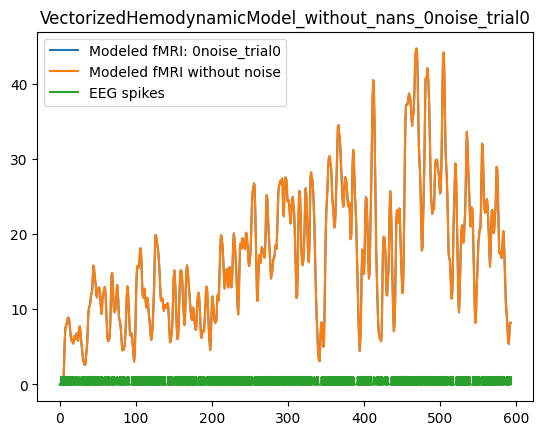

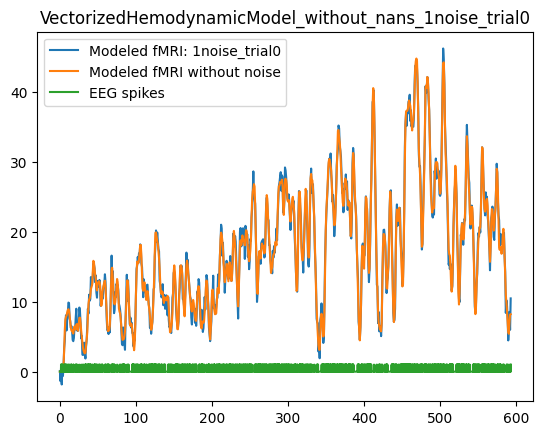

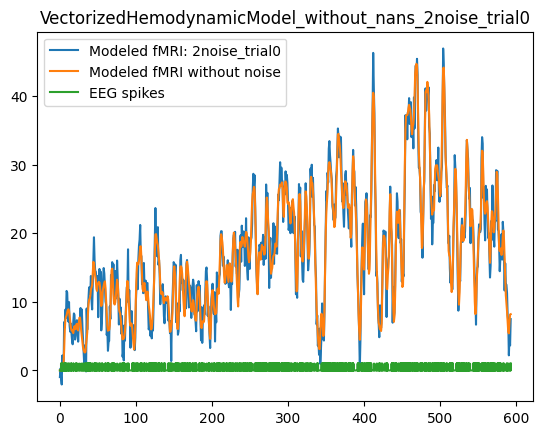

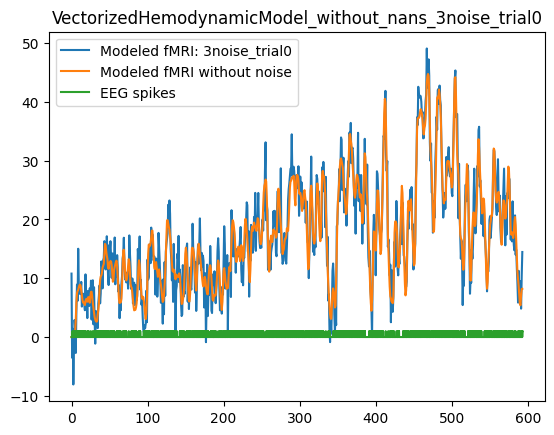

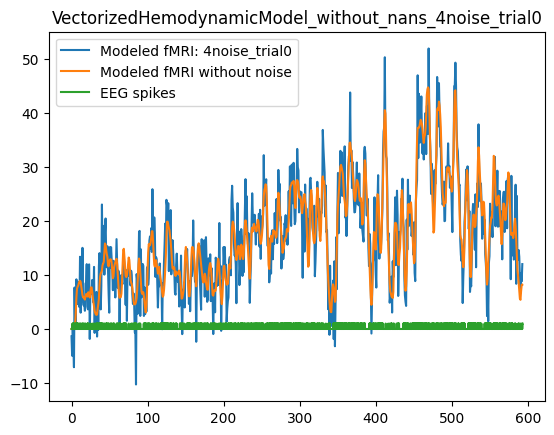

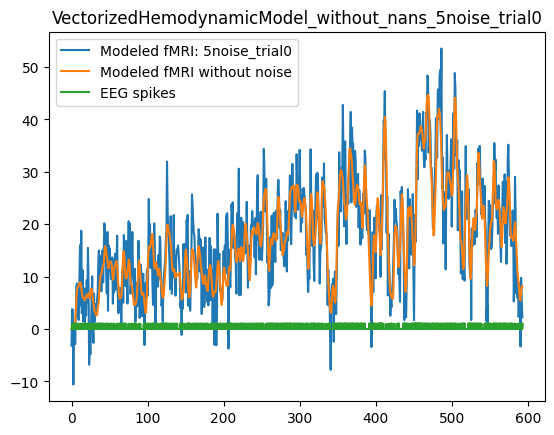

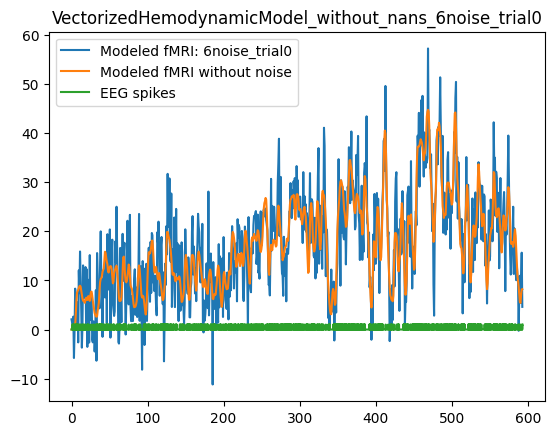

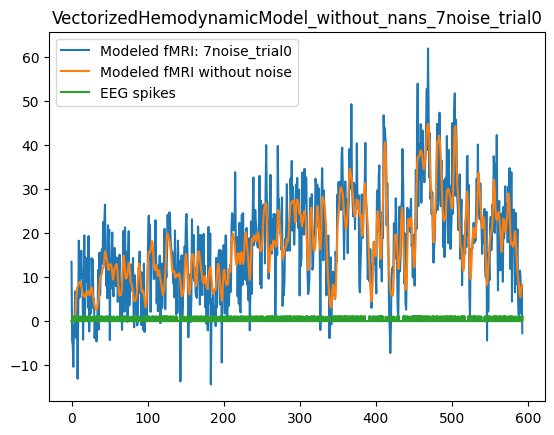

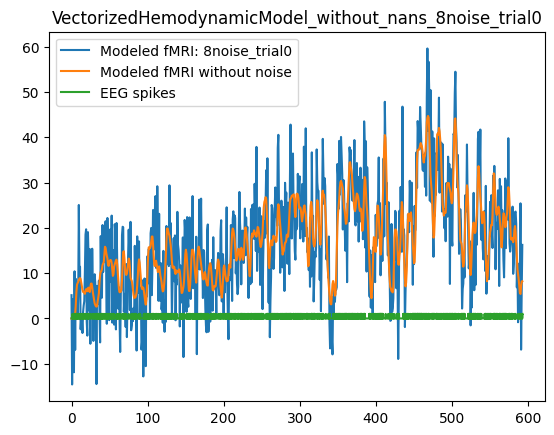

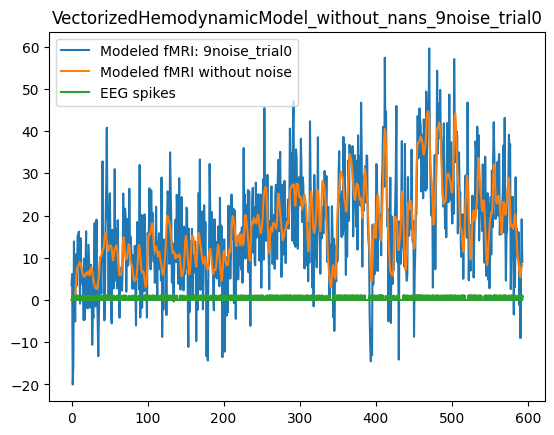

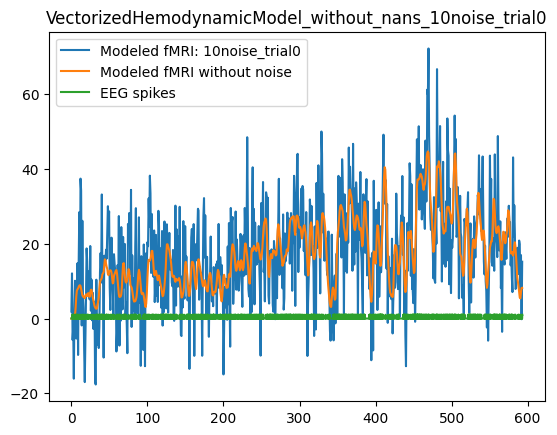

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.35, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.35, alpha=2


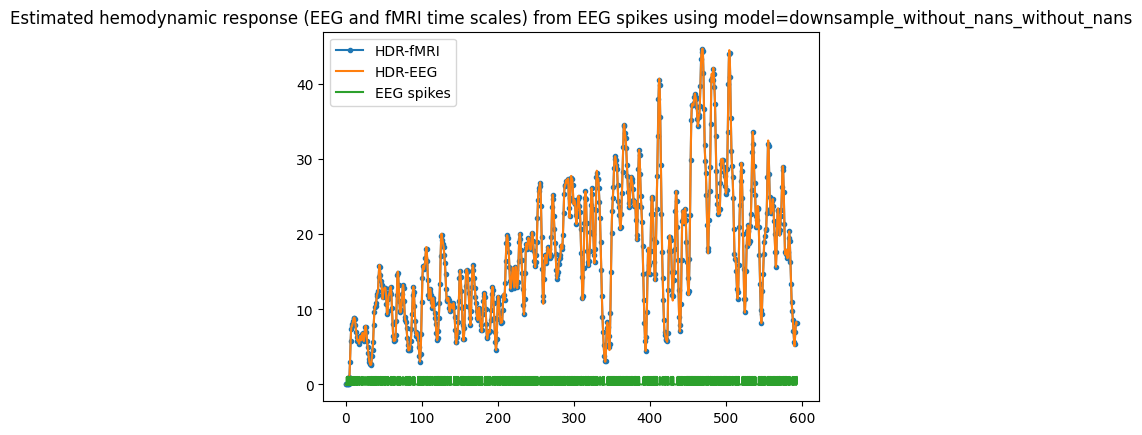

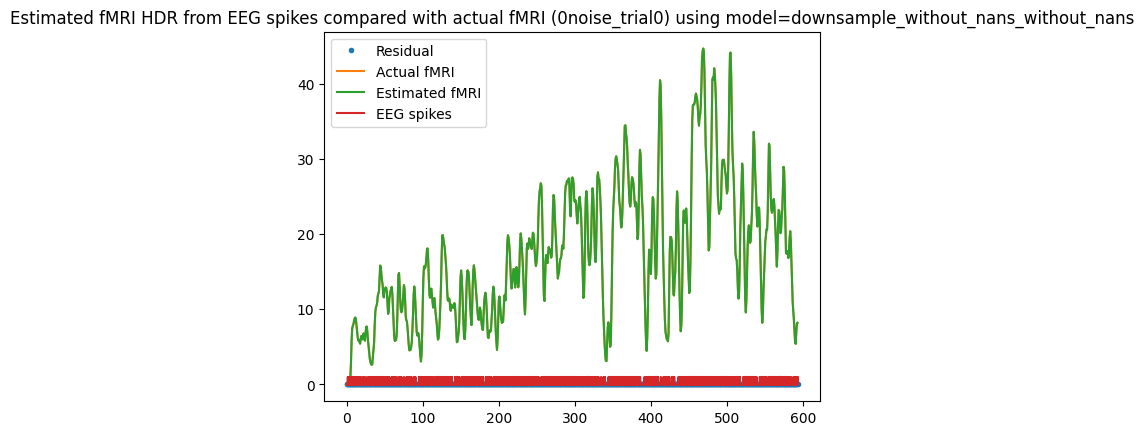

Residual Variance is 0.000000


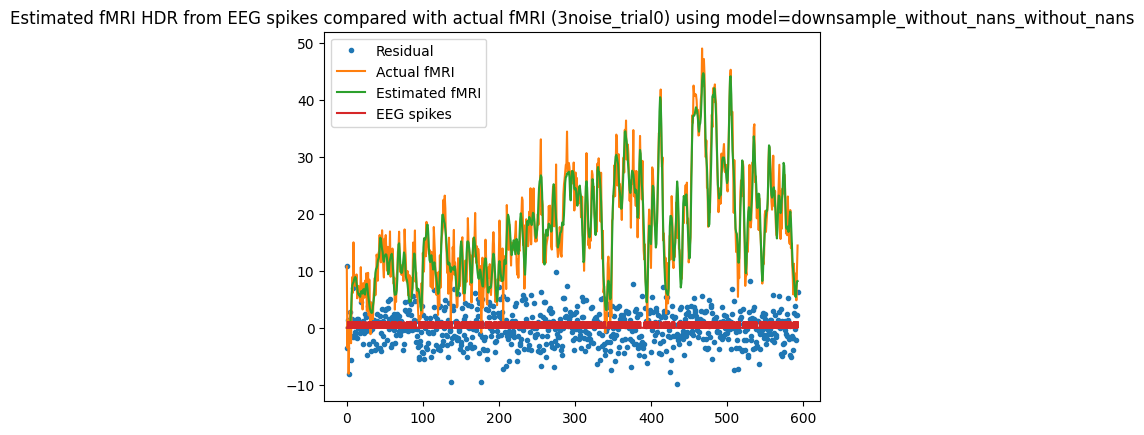

Residual Variance is 9.257846


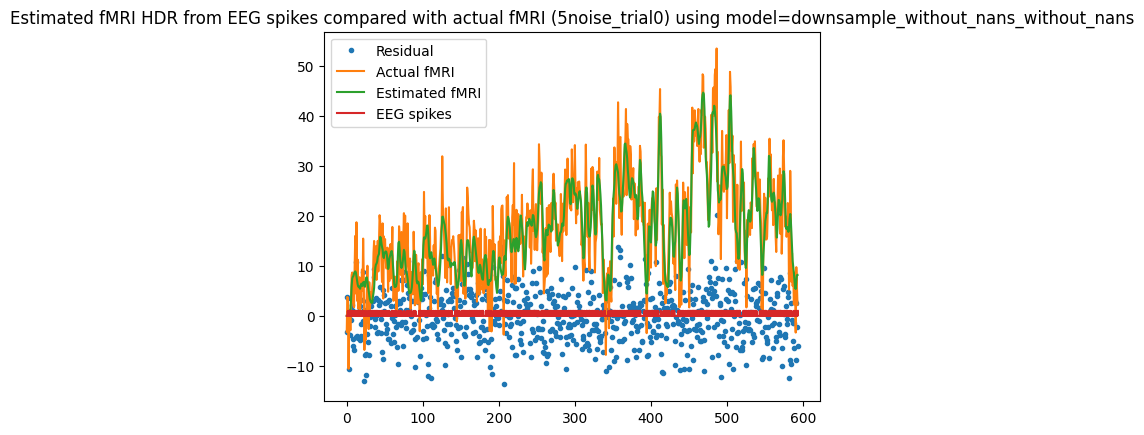

Residual Variance is 26.870564


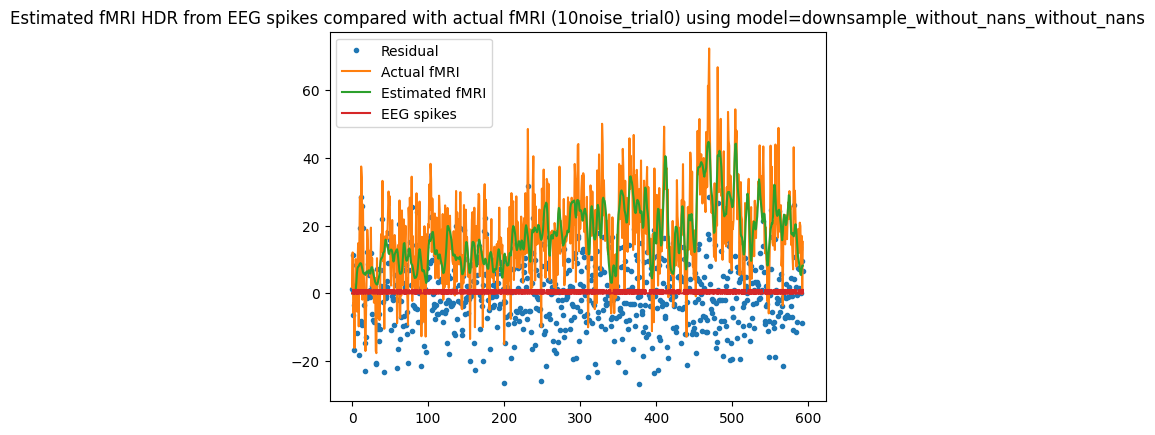

Residual Variance is 103.893377


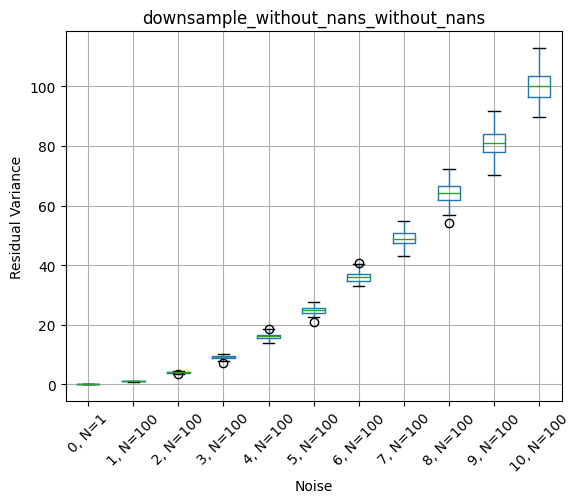

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.35, alpha=2


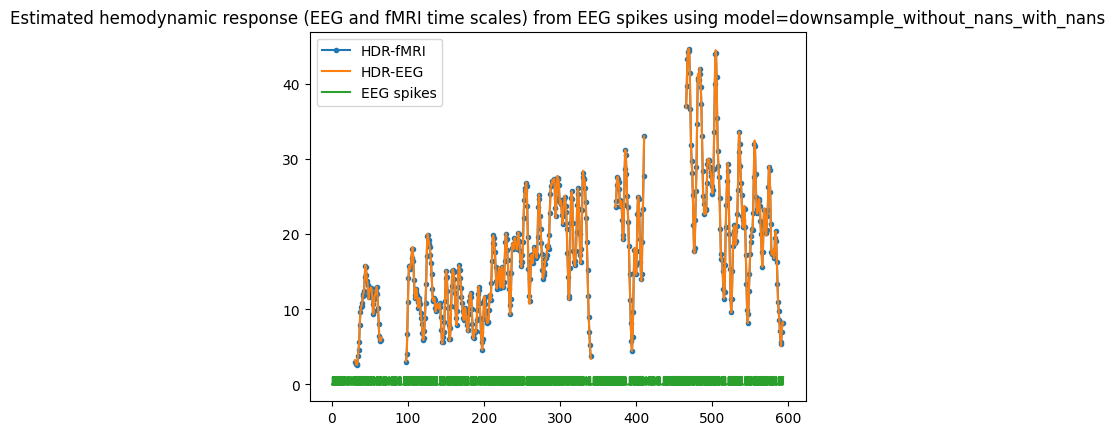

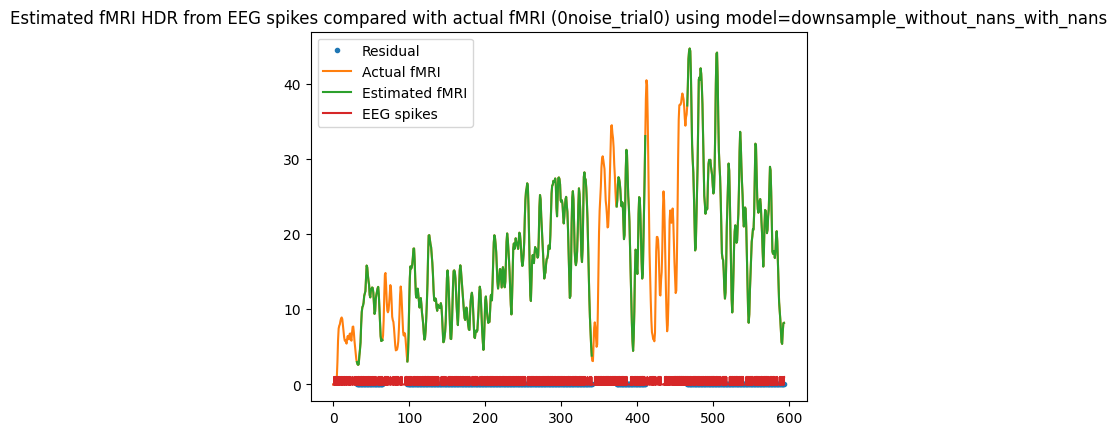

Residual Variance is 0.000000


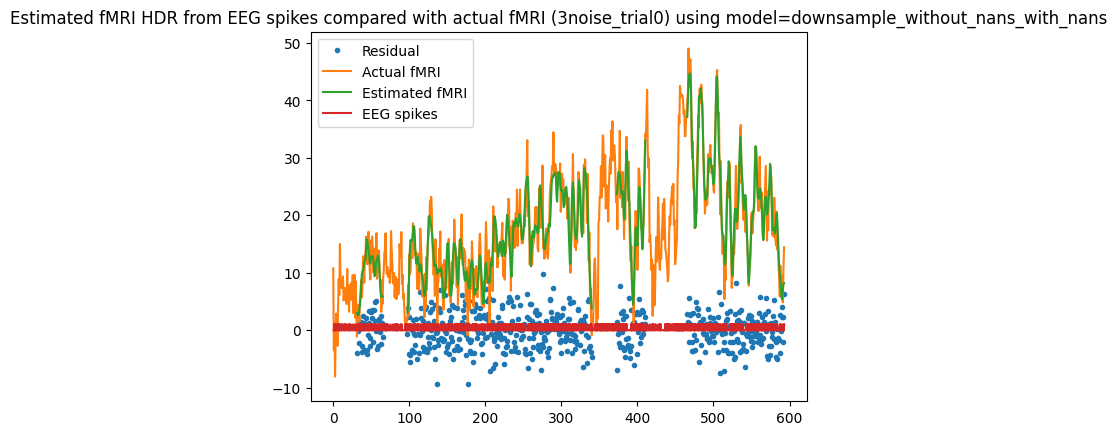

Residual Variance is 9.309839


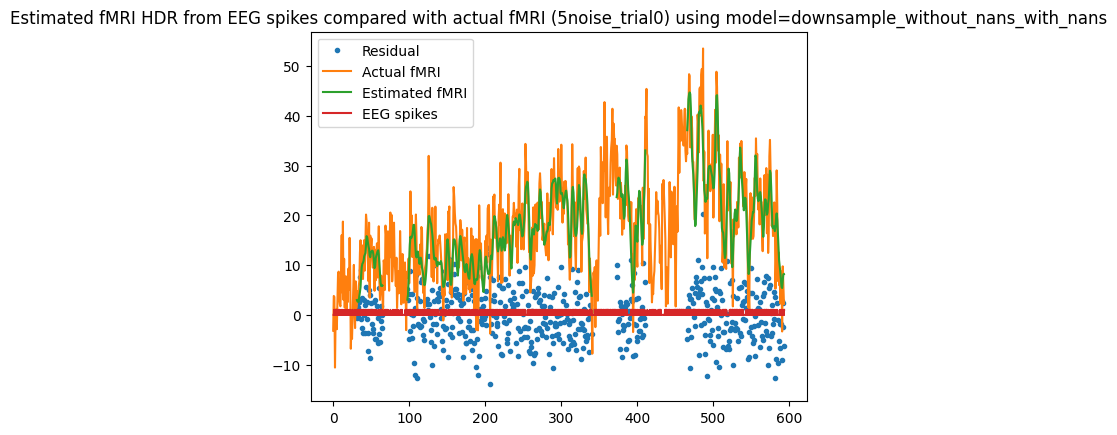

Residual Variance is 26.306996


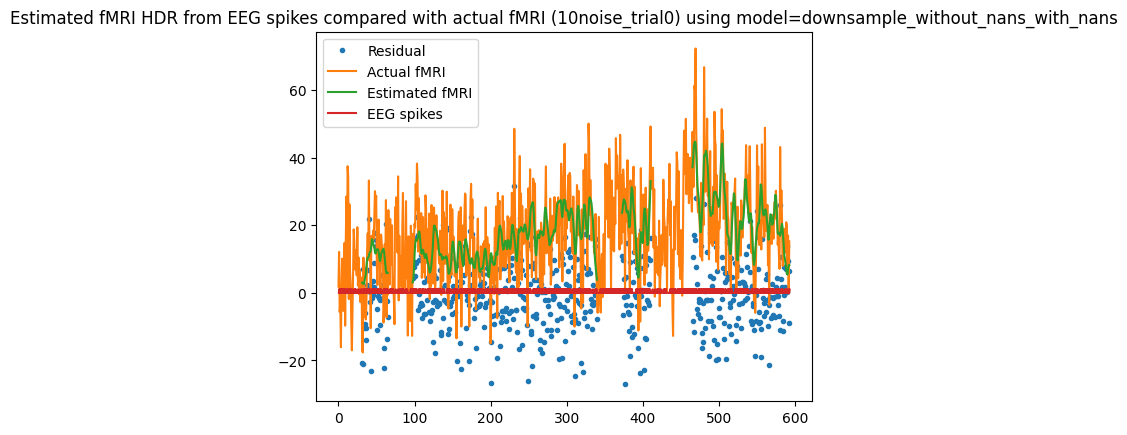

Residual Variance is 102.995165


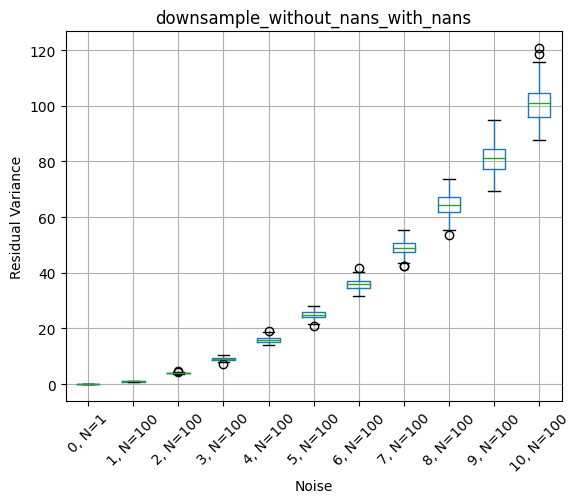

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   50.00638062862564   
1         downsample_without_nans_with_nans  45.294856572594476   
2      downsample_without_nans_without_nans   49.11991180145215   
3         downsample_without_nans_with_nans   44.54497816236194   
4      downsample_without_nans_without_nans  48.223373464094955   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  11.867011695117649   
18938  downsample_without_nans_without_nans   13.80992779065727   
18939     downsample_without_nans_with_nans   12.58331289851478   
18940  downsample_without_nans_without_nans  14.622211393793416   
18941     downsample_without_nans_with_nans  13.298567005515668   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       50.54474168913855   54.17471267494411  58.040642849332926   
1      45.559752289034485   49.63954677836192   53.71726285434545   
2       49.65905576300082   53.30487021600539  57.155789174068175   
3        44.8184027356233  48.900253660393204   52.94897000899264   
4      48.763642489636844   52.42410700474009   56.26319458997184   
...                   ...                 ...                 ...   
18937  12.731113160090297  16.083502018241475  21.186862021268364   
18938  14.672542727098394  18.177109486220402  22.107039563166737   
18939  13.441251694452275  16.803137477480163  21.910370050617114   
18940  15.477137851140066  19.000866591846084    22.8970526546098   
18941  14.150401094612118   17.52189725162008  22.634273890798358   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0         66.925365886656    75.8396388089631  ...   50.11564107646779   
1      60.943679019177615   68.73782998082916  ...   45.49652810268362   
2       66.08892162566306   74.93051852747335  ...    49.2403026624682   
3       60.25668717243036   68.00037607702733  ...  44.759336136647185   
4       65.24116702764644    74.0122113477944  ...   48.35528932966697   
...                   ...                 ...  ...                 ...   
18937  27.992674003972592   38.74774077004433  ...   12.45832166926351   
18938   30.19662161886223   41.10896044749609  ...  14.577114665323947   
18939  28.708663756898748   39.46763515268285  ...  13.151188367209212   
18940  31.009003663719906  41.914659691743715  ...   15.37299876630829   
18941   29.42230999440708    40.1839727765407  ...  13.843224051956241   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       54.27346411840946   59.34791836410659   66.46795938802342   
1      50.171876405869746   55.10801333206783   58.59101590460066   
2       53.36770235488833  58.436069076259535   65.60019979097869   
3       49.41003728208175  54.284566976540276  57.878113205424555   
4       52.45159824122773   57.51438804503117   64.72090270889495   
...                   ...                 ...                 ...   
18937  16.426680763896876   21.87750932803871  25.685078852009525   
18938  18.051412715425208  22.471549693575753  29.191709235991446   
18939  17.146635543021375   22.61741162604498  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 8.566101221606318e-28; at
       delta   tau  alpha
11824   2.25  1.35    2.0


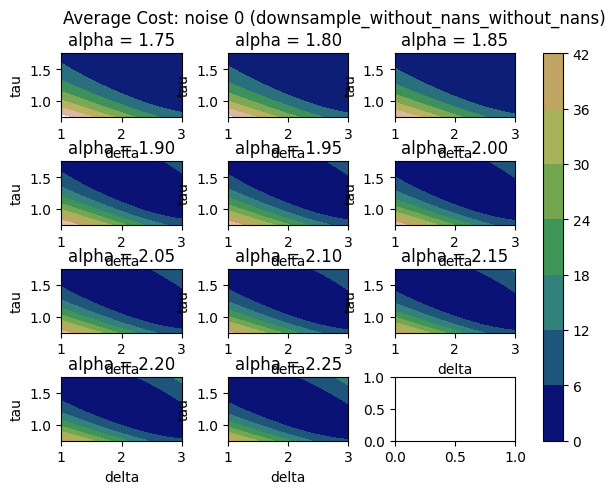

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              50.006381             
2                                              49.119912             
4                                              48.223373             
6                                              47.317401             
8                                              46.402654             
...                                                  ...             
18932                                          11.391827             
18934                                          12.193024             
18936                                          12.999647             
18938                                          13.809928             
18940                                          14.622211             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.35, Alpha target: 2


delta   tau  alpha
0   2.25  1.35    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.35, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  5.586409e-03   2.20  1.30   2.15
1      0         0  8.566101e-28   2.25  1.35   2.00
2      0         0  4.484871e-03   2.35  1.40   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.077440632117843e-28; at
       delta   tau  alpha
11825   2.25  1.35    2.0


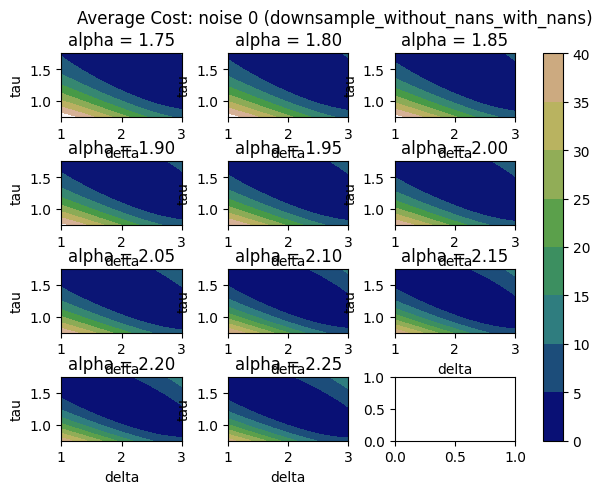

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              45.294857          
3                                              44.544978          
5                                              43.783620          
7                                              43.011276          
9                                              42.228475          
...                                                  ...          
18933                                          10.437499          
18935                                          11.151190          
18937                                          11.867012          
18939                                          12.583313          
18941                                          13.298567          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.35, Alpha target: 2


delta   tau  alpha
0   2.25  1.35    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.35, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  5.553607e-03   2.20  1.30   2.15
1      0         0  1.077441e-28   2.25  1.35   2.00
2      0         0  4.469287e-03   2.35  1.40   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9917722802520301; at
       delta   tau  alpha
11824   2.25  1.35    2.0


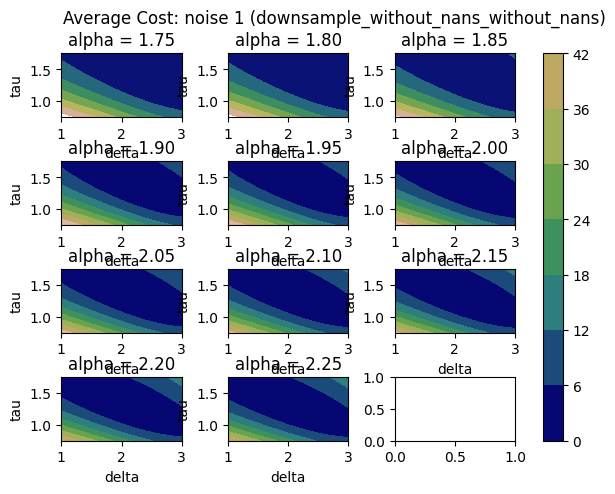

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.0061234199811855; at
       delta   tau  alpha
11824   2.25  1.35    2.0


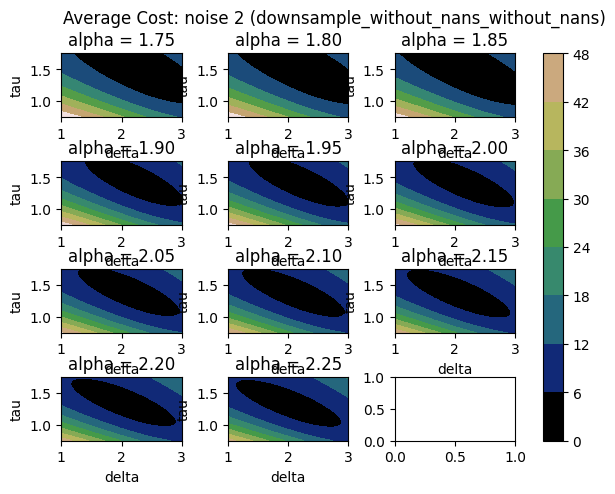

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.999030199536005; at
       delta   tau  alpha
11824   2.25  1.35    2.0


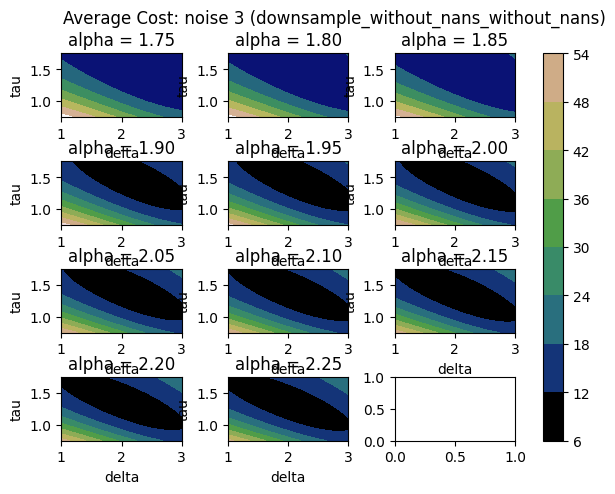

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.034456052174377; at
       delta   tau  alpha
11824   2.25  1.35    2.0


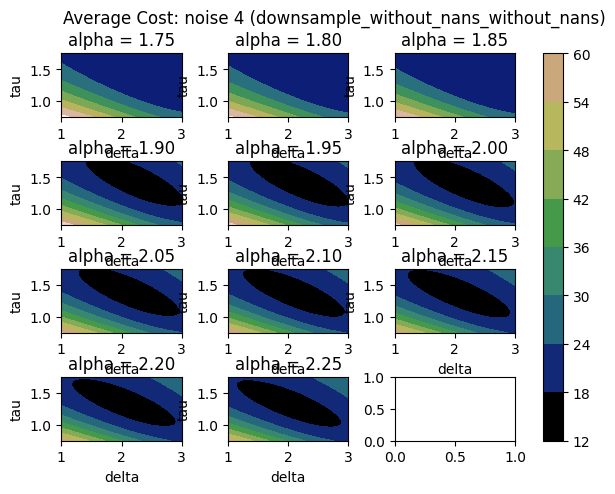

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.876736454269995; at
       delta   tau  alpha
11824   2.25  1.35    2.0


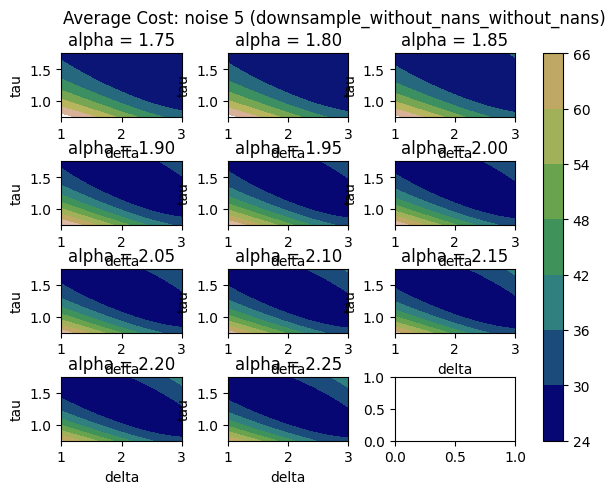

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.000362229034245; at
       delta   tau  alpha
11364    2.2  1.35   2.05


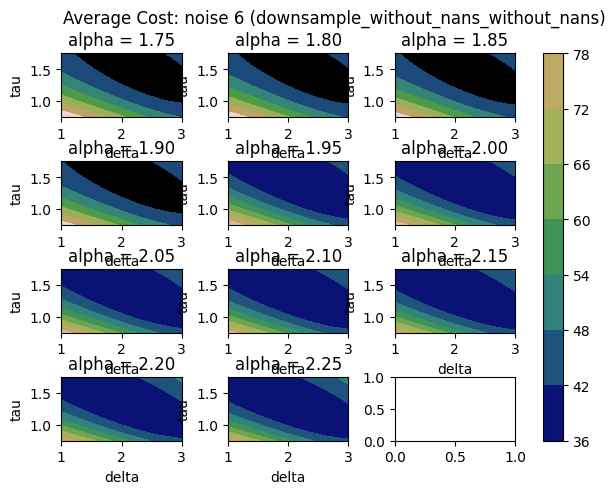

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.988028983901785; at
       delta  tau  alpha
11346    2.2  1.3   2.15


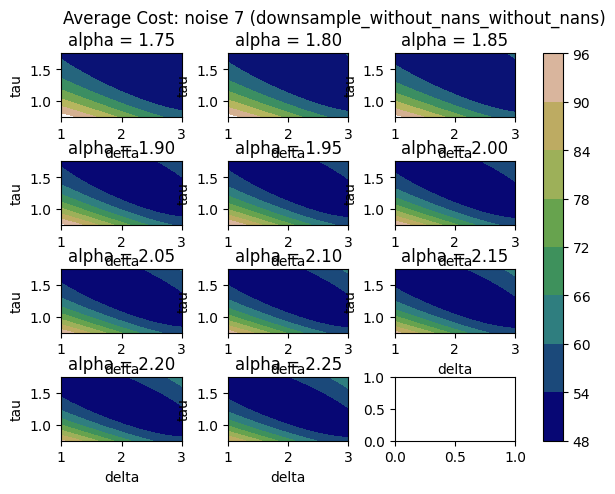

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.2741669136235; at
       delta   tau  alpha
11824   2.25  1.35    2.0


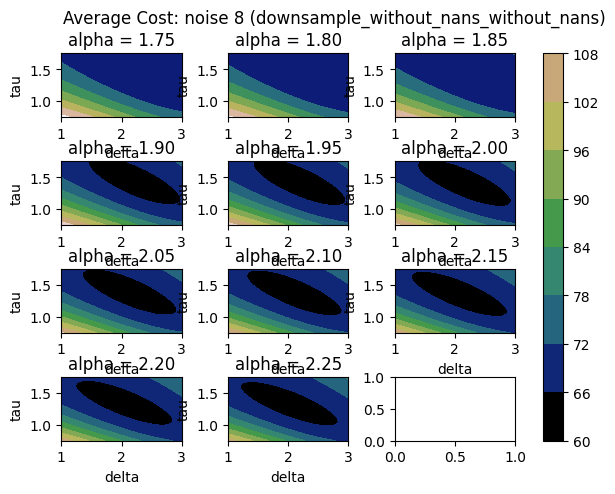

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.22615508758314; at
       delta   tau  alpha
11824   2.25  1.35    2.0


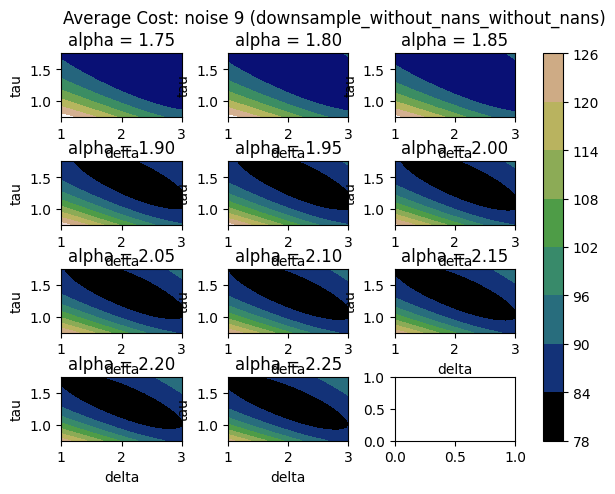

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.31231202987297; at
       delta   tau  alpha
11824   2.25  1.35    2.0


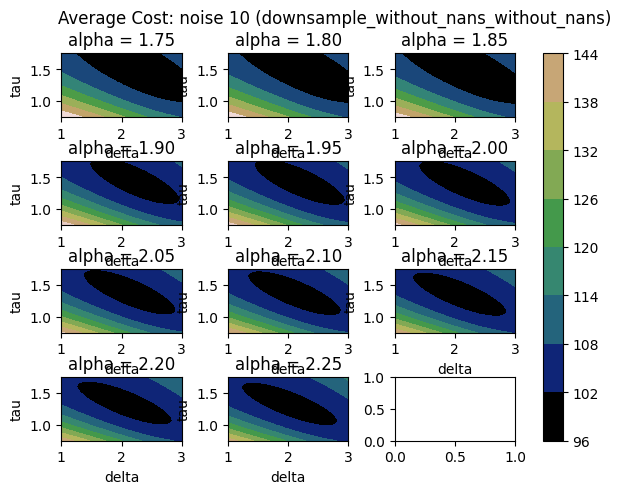

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

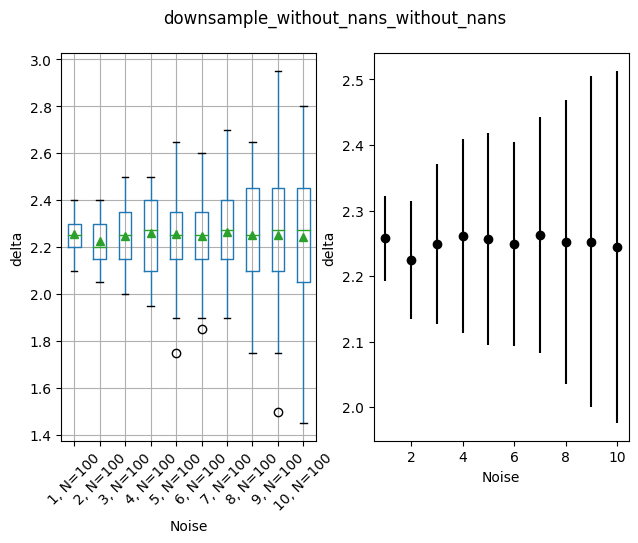

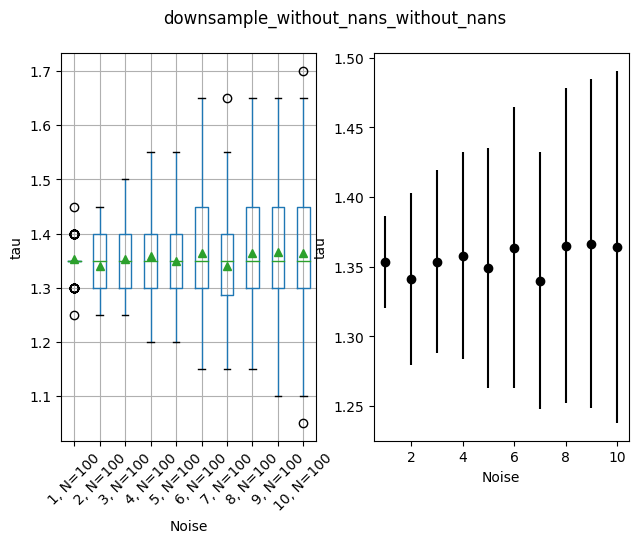

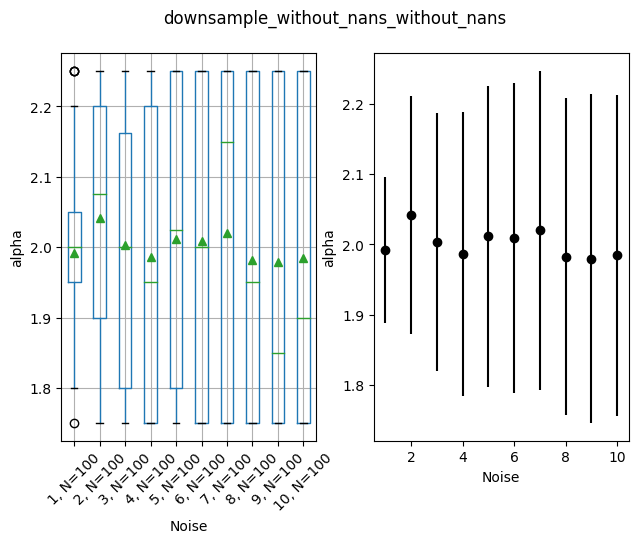

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9925720081719416; at
       delta   tau  alpha
11825   2.25  1.35    2.0


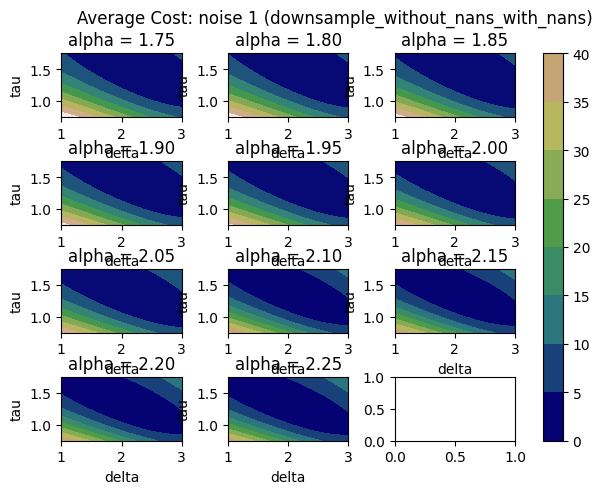

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.01675526522958; at
       delta   tau  alpha
11825   2.25  1.35    2.0


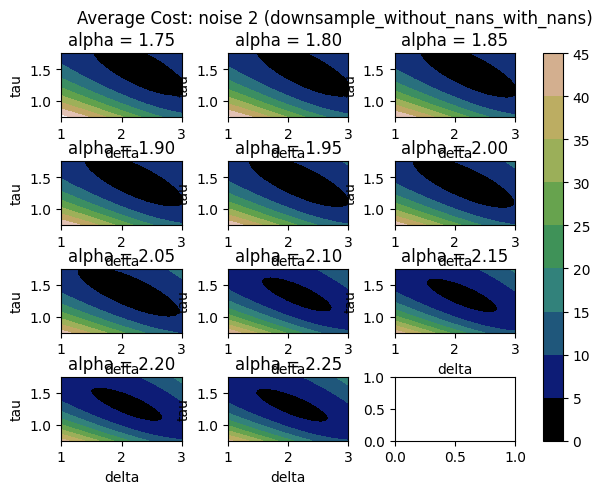

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.033077738410203; at
       delta   tau  alpha
11825   2.25  1.35    2.0


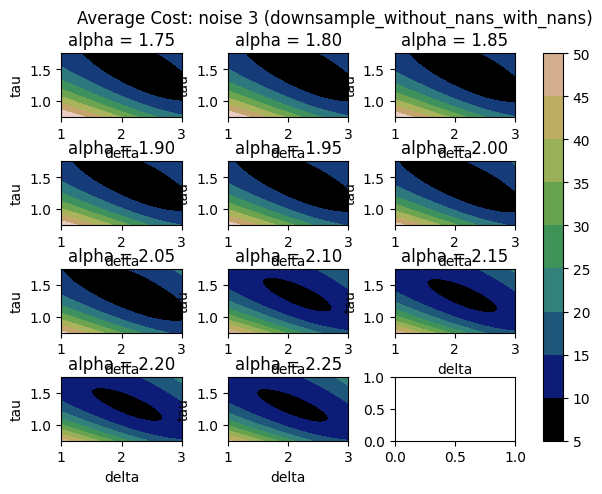

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.95312494843118; at
       delta   tau  alpha
11825   2.25  1.35    2.0


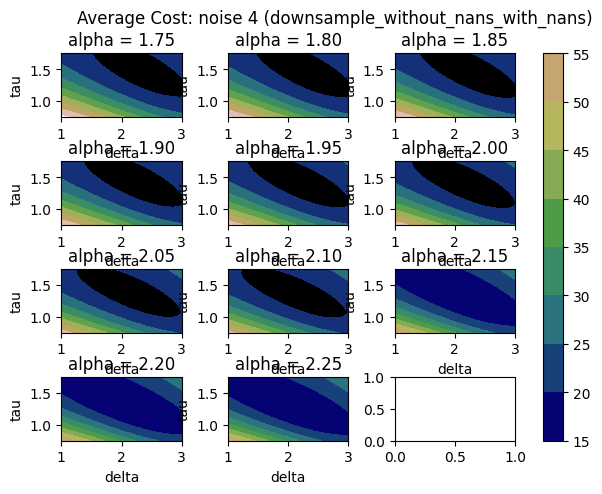

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.792833502303473; at
       delta  tau  alpha
11347    2.2  1.3   2.15


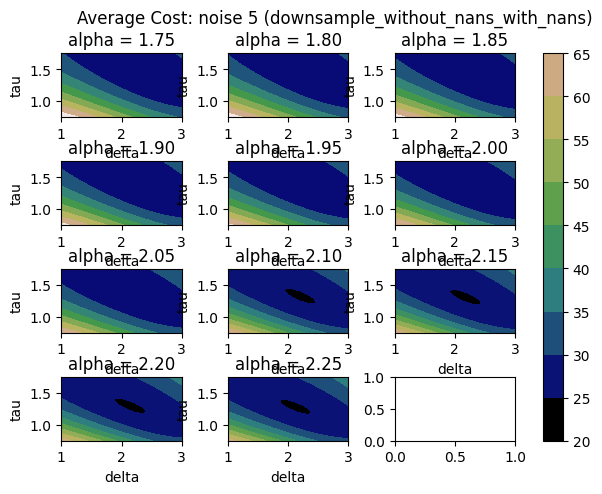

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.995934632650254; at
       delta  tau  alpha
12305    2.3  1.4    1.9


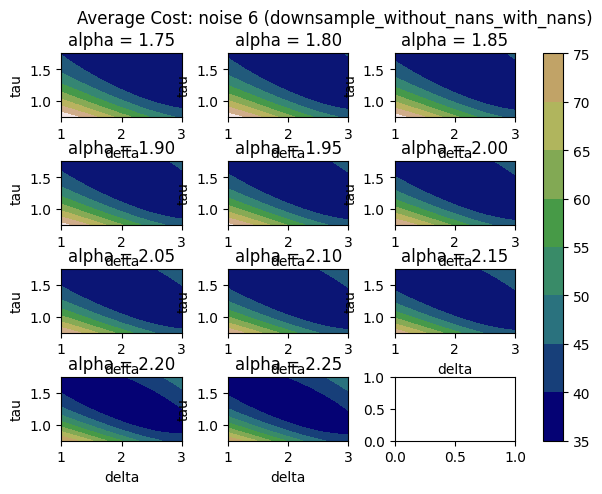

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.98404184340796; at
       delta   tau  alpha
12285    2.3  1.35   1.95


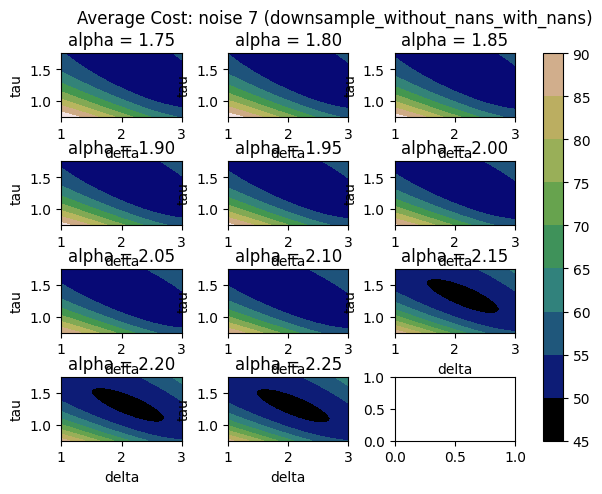

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.25930107518819; at
       delta   tau  alpha
11825   2.25  1.35    2.0


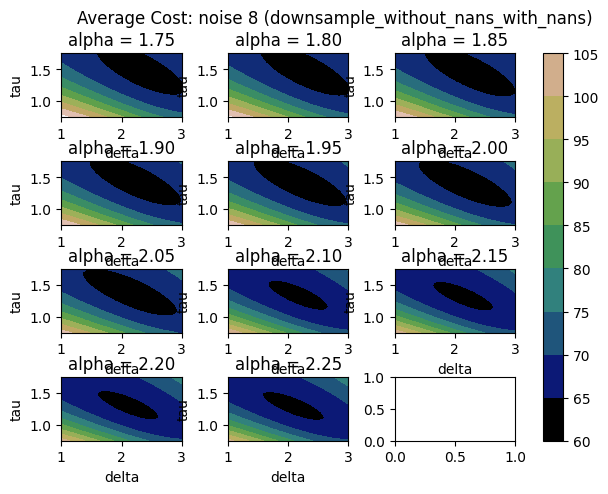

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.12854474889492; at
       delta   tau  alpha
12783   2.35  1.45   1.75


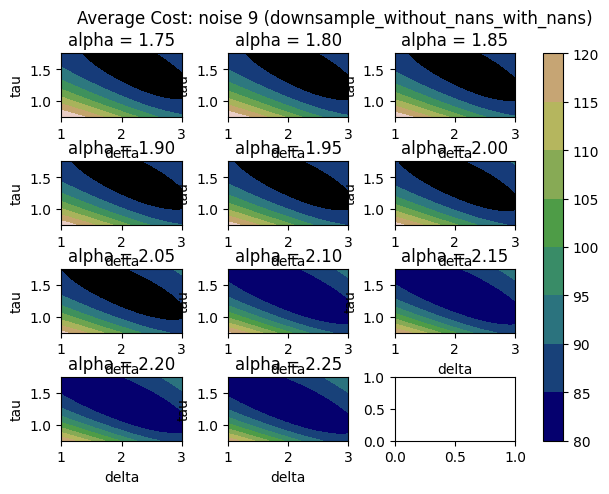

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.65287287335852; at
       delta   tau  alpha
11825   2.25  1.35    2.0


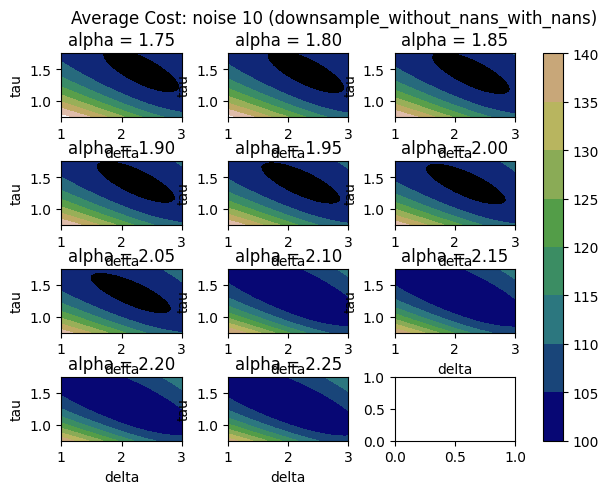

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


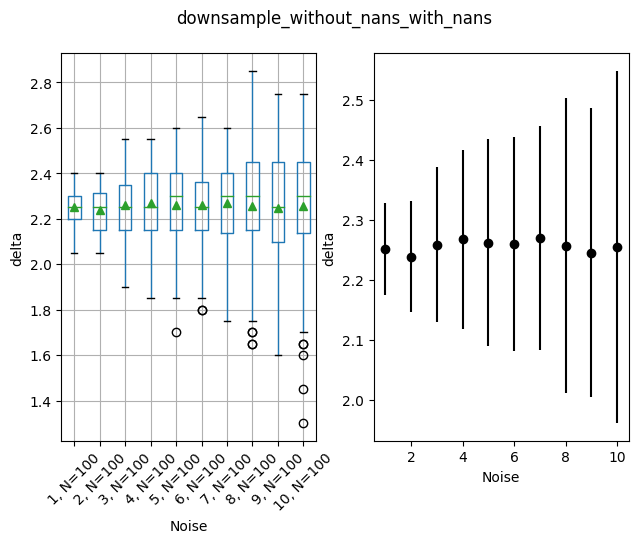

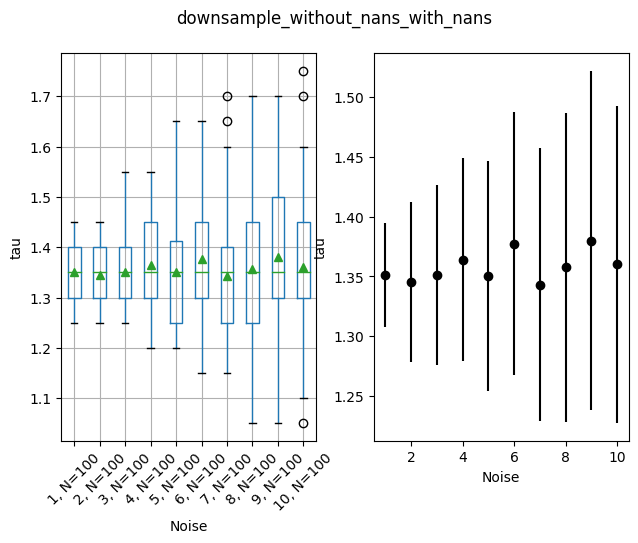

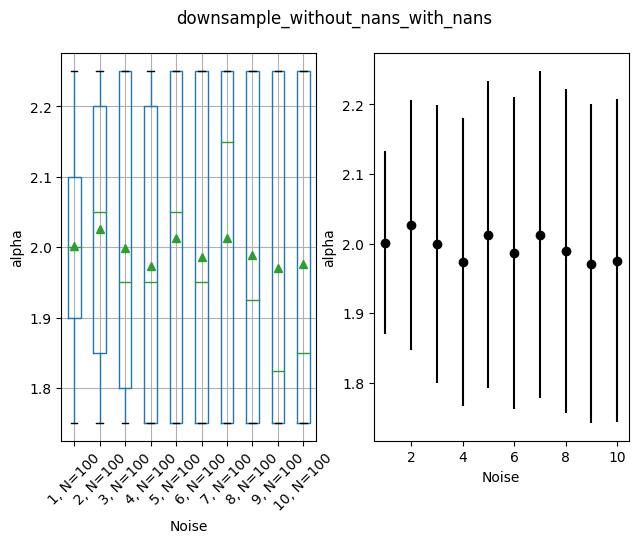

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         0    0.981011   2.100000000000001  1.3000000000000005   
1         1         9    0.956972   2.100000000000001  1.3000000000000005   
2         1        23    0.933563   2.100000000000001  1.3000000000000005   
3         1        27    1.030777   2.100000000000001  1.3000000000000005   
4         1        38    0.954266   2.100000000000001  1.3000000000000005   
...     ...       ...         ...                 ...                 ...   
2722     10        86   99.548899  2.6500000000000012  1.3000000000000005   
2723     10        45  101.282912  2.7000000000000015  1.0500000000000003   
2724     10         4  110.345889  2.7000000000000015  1.2500000000000004   
2725     10        64   98.330233  2.7000000000000015  1.3500000000000005   
2726     10        79   97.449939  2.8000000000000016  1.2000000000000004   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2722                1.75  
2723  2.2500000000000004  
2724                1.75  
2725                1.75  
2726                1.75  

[2727 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.67  0.603943  2.0  3.0  4.0  4.0  5.0
2                      100.0  3.52  0.658741  2.0  3.0  4.0  4.0  5.0
3                      100.0  3.38  0.813770  1.0  3.0  4.0  4.0  5.0
4                      100.0  3.01  0.926545  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.69  1.021931  1.0  2.0  3.0  3.0  5.0
6                      100.0  2.49  1.210184  1.0  1.0  2.0  4.0  6.0
7                      100.0  2.39  1.196755  1.0  1.0  2.0  4.0  5.0
8                      100.0  2.25  1.166667  1.0  1.0  2.0  3.0  5.0
9                      100.0  2.00  1.214392  1.0  1.0  1.0  3.0  5.0
10                     100.0  1.87  1.142874  1.0  1.0  1.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
309       1         0    0.989160  2.3500000000000014  1.4500000000000006   
310       1         2    0.956367  2.3500000000000014  1.4500000000000006   
311       1         6    1.034493  2.3500000000000014  1.4500000000000006   
312       1         9    0.963566  2.3500000000000014  1.4500000000000006   
313       1        17    1.003637  2.3500000000000014  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2721     10         5   96.141761  2.6500000000000012  1.3000000000000005   
2722     10        86   99.548899  2.6500000000000012  1.3000000000000005   
2724     10         4  110.345889  2.7000000000000015  1.2500000000000004   
2725     10        64   98.330233  2.7000000000000015  1.3500000000000005   
2726     10        79   97.449939  2.8000000000000016  1.2000000000000004   

     alpha  
309   1.75  
310   1.75  
311   1.75  
312   1.75  
313   1.75  
...    ...  
2721  1.75  
2722  1.75  
2724  1.75  
2725  1.75  
2726  1.75  

[407 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        42      2  2.3500000000000014   35    42      1  1.4500000000000006   
10       43     16  2.5000000000000013    6    43     10  1.4500000000000006   
2        30      4  2.3500000000000014   20    30      3  1.4500000000000006   
3        37      6  2.3500000000000014   11    37      3  1.4500000000000006   
4        35      7   2.450000000000001   12    35      5  1.4000000000000006   
5        32     10  2.3500000000000014    7    32      5  1.4500000000000006   
6        41     10  2.3500000000000014    9    41      7  1.4000000000000006   
7        45     13   2.450000000000001   12    45      7  1.4500000000000006   
8        47     14   2.450000000000001    8    47     10  1.4500000000000006   
9        55     17   2.450000000000001   11    55     10  1.4000000000000006   

            
      freq  
noise       
1       42  
10      11  
2       25  
3       20  
4       15  
5       14  
6       14  
7       15  
8       11  
9       16

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
13        1         3    0.938201   2.100000000000001  1.3000000000000005   
14        1        18    0.922593   2.100000000000001  1.3000000000000005   
15        1        28    0.950746   2.100000000000001  1.3000000000000005   
16        1        45    0.891239   2.100000000000001  1.3000000000000005   
17        1         1    1.012979  2.1500000000000012  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2687     10        68   91.107913   2.450000000000001  1.1500000000000004   
2688     10        12   94.595655   2.450000000000001  1.2000000000000004   
2702     10        28  100.562313  2.5000000000000013  1.2500000000000004   
2720     10        77  110.588980  2.6500000000000012  1.1000000000000003   
2723     10        45  101.282912  2.7000000000000015  1.0500000000000003   

                   alpha  
13    2.2500000000000004  
14    2.2500000000000004  
15    2.2500000000000004  
16    2.2500000000000004  
17    2.2500000000000004  
...                  ...  
2687  2.2500000000000004  
2688  2.2500000000000004  
2702  2.2500000000000004  
2720  2.2500000000000004  
2723  2.2500000000000004  

[396 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        26      3  2.1500000000000012   18    26      2  1.2500000000000004   
10       42     17  1.9000000000000008    5    42      9  1.3000000000000005   
2        39      5  2.1500000000000012   21    39      2  1.2500000000000004   
3        40      6   2.200000000000001   11    40      4  1.2500000000000004   
4        46      9   2.100000000000001   14    46      4  1.3000000000000005   
5        41     11  2.1500000000000012    7    41      5  1.2500000000000004   
6        40     11  2.1500000000000012    7    40      6  1.3000000000000005   
7        44     12  2.1500000000000012    8    44      6  1.2500000000000004   
8        35     14  1.9000000000000008    5    35      6  1.2500000000000004   
9        43     17  2.1500000000000012    7    43      9  1.3000000000000005   

            
      freq  
noise       
1       22  
10      17  
2       28  
3       23  
4       23  
5       16  
6       13  
7       16  
8       10  
9       13

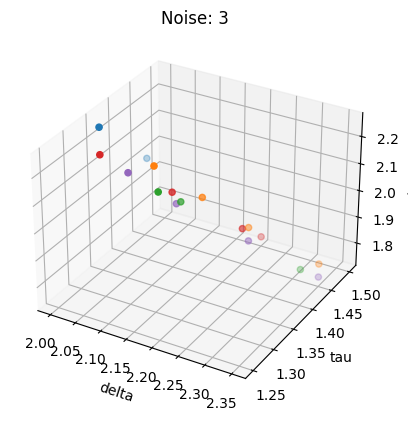

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

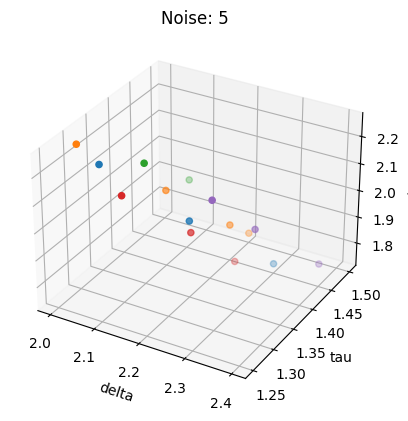

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

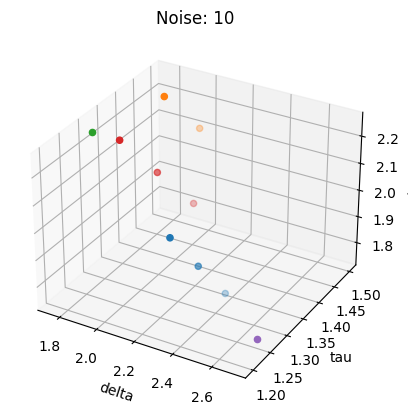

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        85    0.995480  2.0500000000000007  1.3000000000000005   
1         1         0    0.962098   2.100000000000001  1.3000000000000005   
2         1         6    0.954066   2.100000000000001  1.3000000000000005   
3         1        23    0.956672   2.100000000000001  1.3000000000000005   
4         1        24    1.009971   2.100000000000001  1.3000000000000005   
...     ...       ...         ...                 ...                 ...   
2553     10        79   99.259338  2.7500000000000018  1.1500000000000004   
2554     10        86  100.331910  2.7500000000000018  1.2000000000000004   
2555     10        58  118.007990  2.7500000000000018  1.2500000000000004   
2556     10        64  101.686155  2.7500000000000018  1.3000000000000005   
2557     10        17  108.125961  2.7500000000000018  1.3500000000000005   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2553                1.75  
2554                1.75  
2555                1.75  
2556                1.75  
2557                1.75  

[2558 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.57  0.555141  2.0  3.0  4.0  4.0  5.0
2                      100.0  3.37  0.824560  1.0  3.0  4.0  4.0  5.0
3                      100.0  3.24  0.954733  1.0  3.0  3.0  4.0  5.0
4                      100.0  2.84  1.212061  1.0  2.0  3.0  4.0  5.0
5                      100.0  2.48  1.226640  1.0  1.0  3.0  3.0  6.0
6                      100.0  2.16  1.228615  1.0  1.0  2.0  3.0  6.0
7                      100.0  2.05  1.225775  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.19  1.211852  1.0  1.0  2.0  3.0  5.0
9                      100.0  1.98  1.205878  1.0  1.0  1.0  3.0  6.0
10                     100.0  1.70  1.020002  1.0  1.0  1.0  2.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost               delta                 tau alpha
2389     10        72  97.674526  1.4500000000000004  1.7500000000000009  1.75

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
308       1         0    0.968565  2.3500000000000014  1.4500000000000006   
309       1         6    0.962971  2.3500000000000014  1.4500000000000006   
310       1         8    0.984449  2.3500000000000014  1.4500000000000006   
311       1        15    0.945591  2.3500000000000014  1.4500000000000006   
312       1        17    0.983931  2.3500000000000014  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2553     10        79   99.259338  2.7500000000000018  1.1500000000000004   
2554     10        86  100.331910  2.7500000000000018  1.2000000000000004   
2555     10        58  118.007990  2.7500000000000018  1.2500000000000004   
2556     10        64  101.686155  2.7500000000000018  1.3000000000000005   
2557     10        17  108.125961  2.7500000000000018  1.3500000000000005   

     alpha  
308   1.75  
309   1.75  
310   1.75  
311   1.75  
312   1.75  
...    ...  
2553  1.75  
2554  1.75  
2555  1.75  
2556  1.75  
2557  1.75  

[415 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        36      3  2.3500000000000014   29    36      2  1.4500000000000006   
10       52     16   2.300000000000001    7    52     12  1.4000000000000006   
2        38      4  2.3500000000000014   20    38      3  1.4500000000000006   
3        26      7   2.300000000000001    6    26      4  1.4500000000000006   
4        42      8  2.4000000000000012   12    42      5  1.4500000000000006   
5        36     11  2.4000000000000012   10    36      7  1.4500000000000006   
6        46     13  2.4000000000000012   10    46      8  1.5000000000000007   
7        44     12  2.4000000000000012    9    44      9  1.4000000000000006   
8        46     15  2.5000000000000013    7    46     11  1.4500000000000006   
9        49     14   2.300000000000001    9    49     10  1.5000000000000007   

            
      freq  
noise       
1       35  
10      13  
2       33  
3       12  
4       19  
5       11  
6       12  
7       15  
8        9  
9        8

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        85    0.995480  2.0500000000000007  1.3000000000000005   
14        1         3    0.956133   2.100000000000001  1.3000000000000005   
15        1        18    0.905521   2.100000000000001  1.3000000000000005   
16        1        22    0.991933   2.100000000000001  1.3000000000000005   
17        1        28    0.945846   2.100000000000001  1.3000000000000005   
...     ...       ...         ...                 ...                 ...   
2514     10        12   97.890831   2.450000000000001  1.1500000000000004   
2519     10        59  104.959326   2.450000000000001  1.2500000000000004   
2526     10        77  107.474637  2.5000000000000013  1.1000000000000003   
2528     10        31  107.315937  2.5000000000000013  1.2000000000000004   
2549     10        45  101.286939  2.6500000000000012  1.0500000000000003   

                   alpha  
0     2.2500000000000004  
14    2.2500000000000004  
15    2.2500000000000004  
16    2.2500000000000004  
17    2.2500000000000004  
...                  ...  
2514  2.2500000000000004  
2519  2.2500000000000004  
2526  2.2500000000000004  
2528  2.2500000000000004  
2549  2.2500000000000004  

[435 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        27      4  2.1500000000000012   19    27      2  1.2500000000000004   
10       44     20  2.1500000000000012    5    44     10  1.3000000000000005   
2        41      5  2.1500000000000012   13    41      2  1.2500000000000004   
3        52     10   2.200000000000001   16    52      4  1.2500000000000004   
4        40      8  2.1500000000000012   17    40      4  1.2500000000000004   
5        44     10   2.100000000000001    9    44      5  1.2500000000000004   
6        42     11   2.250000000000001    9    42      7  1.3000000000000005   
7        48     14  2.1500000000000012    7    48      8  1.2500000000000004   
8        50     17   2.300000000000001    7    50     10  1.3000000000000005   
9        47     20   2.250000000000001    5    47     11  1.3000000000000005   

            
      freq  
noise       
1       21  
10      11  
2       22  
3       32  
4       21  
5       17  
6       11  
7       15  
8       10  
9       11

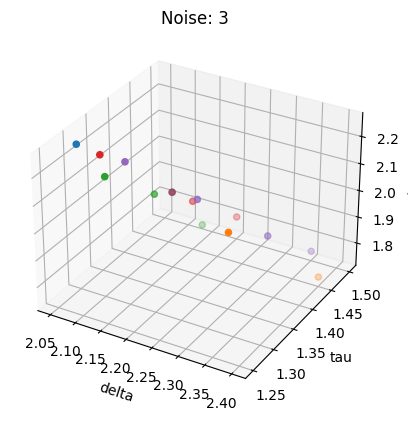

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

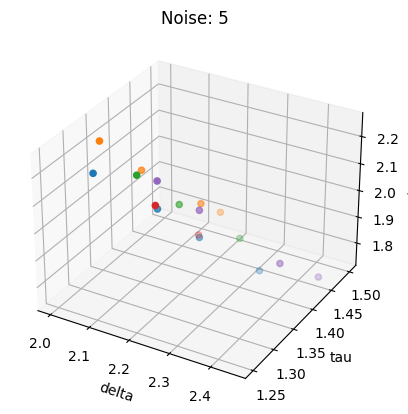

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

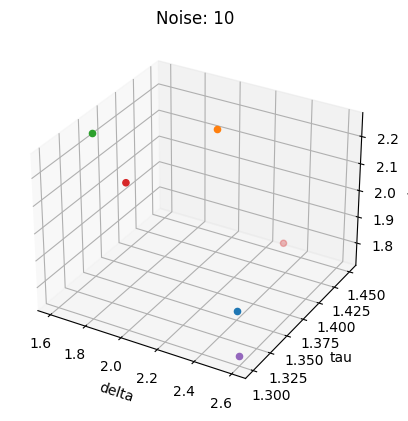

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()